# Baseline model: logistic regression -> add more ML classifiers 
Date: 2020-05-25

- Features to be included:
    1. Counts (CountVecterizer + TF-IDF correction + inspection)
        - unigram 
        - bigram 
        - trigram
    2. Feature generated by manually extracted data 
        - avg work experience 
        - job hoppers (binary)
        - competitor experience (binary) 
        - others to be concerned (education-related) 
- Accuracy evaluation -> cross validation???
    1. Accuracy
    2. Confusion matrix 
    3. Recall, Precision, F1-score, ROC plot 
- Other models -> build a pipeline 
    1. SVM 
    2. Random Forest 
    3. Boosting
    4. Multiple Perceptron 

In [1298]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import string 
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from regressors import stats
from sklearn.feature_selection import chi2

In [1299]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
            
    """    
    print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
    print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))

In [1300]:
# Load dataset 
train_original = pd.read_csv("../data/train_dataset.csv")
test_original = pd.read_csv("../data/test_dataset.csv")
resume_original = pd.read_csv("../data/05182020_cleaned_english_resumes_V1.0.csv")
avg_work = pd.read_csv("../result/avg_work_exp.csv")
competitor = pd.read_csv("../result/competitor_experience.csv")

In [1301]:
# Prepare train and test datasets
train = pd.merge(train_original, resume_original, how="left", on="employee_code").merge(
                                     avg_work, how="left", on="employee_code").merge(
                                     competitor, how="left", on="employee_code"
                )[["employee_code", "raw_resume", "resume_text", "resume_bline", "clean_text", "job_hopper", "competitor_experience", "hp_class"]]

test = pd.merge(test_original, resume_original, how="left", on="employee_code"
               )[["employee_code", "raw_resume", "resume_text", "resume_bline", "clean_text", "hp_class"]]
X_train = train["clean_text"]
y_train = train["hp_class"]
X_test = test["clean_text"]
y_test = test["hp_class"]

# Count Vectorizer

In [1302]:
vec = CountVectorizer(max_features=5000, ngram_range=(2, 2))
X_train_counts = vec.fit_transform(X_train) 
X_test_counts = vec.transform(X_test)

In [1243]:
parameters = {'C':[0.05, 0.06, 0.07, 0.08, 0.1], 'l1_ratio':np.linspace(0,0.2,3)}
lr = LogisticRegression(class_weight="balanced", solver='saga', penalty='elasticnet')
clf = GridSearchCV(lr, parameters, cv=4)

In [1244]:
clf.fit(X_train_counts, y_train)
show_scores(clf,X_train_counts, y_train, X_test_counts, y_test)
print("Best param is: ", clf.best_params_)

Training error:   0.00
Validation error: 0.26
Best param is:  {'C': 0.05, 'l1_ratio': 0.0}


Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

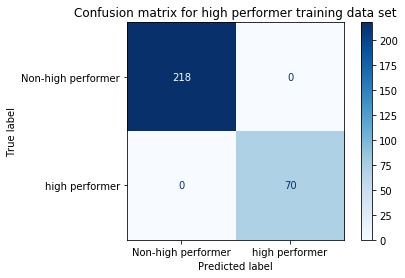

In [1245]:
disp = plot_confusion_matrix(clf, X_train_counts, y_train,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

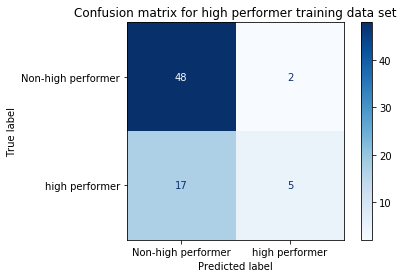

In [1246]:
disp = plot_confusion_matrix(clf, X_test_counts, y_test,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

In [1247]:
predictions = clf.predict(X_train_counts)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       218
         1.0       1.00      1.00      1.00        70

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [1248]:
predictions = clf.predict(X_test_counts)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.74      0.96      0.83        50
         1.0       0.71      0.23      0.34        22

    accuracy                           0.74        72
   macro avg       0.73      0.59      0.59        72
weighted avg       0.73      0.74      0.69        72



# Restart

In [1281]:
scores, pvalues = chi2(X_train_counts, y_train)

In [1293]:
scores

array([0.13289646, 0.22421065, 0.13289646, ..., 0.96330275, 0.00104849,
       0.96330275])

---

In [1263]:
lr = LogisticRegression(class_weight="balanced", solver='saga', penalty='elasticnet', C=0.04, l1_ratio=0.1)
lr.fit(X_train_counts, y_train)
show_scores(lr,X_train_counts, y_train, X_test_counts, y_test)

Training error:   0.24
Validation error: 0.36


Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

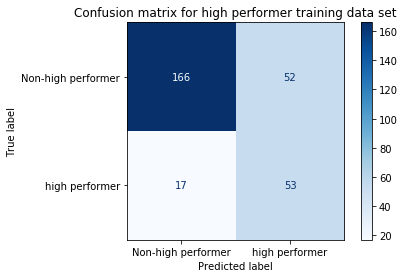

In [1264]:
disp = plot_confusion_matrix(lr, X_train_counts, y_train,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

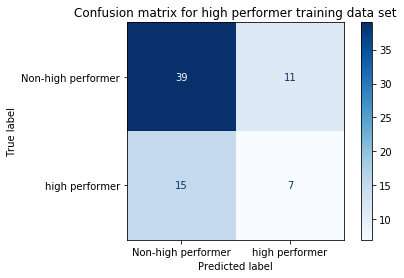

In [1265]:
disp = plot_confusion_matrix(lr, X_test_counts, y_test,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

In [1259]:
predictions = lr.predict(X_train_counts)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.56      0.68       218
         1.0       0.34      0.73      0.47        70

    accuracy                           0.60       288
   macro avg       0.60      0.64      0.57       288
weighted avg       0.74      0.60      0.63       288



In [1260]:
predictions = lr.predict(X_test_counts)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        50
         1.0       0.38      0.55      0.44        22

    accuracy                           0.58        72
   macro avg       0.56      0.57      0.56        72
weighted avg       0.64      0.58      0.60        72



--- 
## Start here: add significance 

In [1306]:
vec = CountVectorizer(max_features=5000, ngram_range=(2, 2))
X_train_counts = vec.fit_transform(X_train) 
X_test_counts = vec.transform(X_test)

In [1307]:
lr = LogisticRegression()
lr.fit(X_train_counts, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1308]:
# Get features (words in our case)
vocab = vec.get_feature_names()
weights = lr.coef_.flatten()
scores, pvalues = chi2(X_train_counts, y_train)

# Sort the coefficients in descending order 
inds = np.argsort(lr.coef_.flatten())

# pick the first 20 as most informative features for negative reviews  
negative_words = [vocab[index] for index in inds[:20]]

# pick the last 20 features as most informative features for positive reviews  
positive_words = [vocab[index] for index in inds[-20:][::-1]]

neg_words_weights = [(weights[index]) for index in inds[:20]]
pos_words_weights = [(weights[index]) for index in inds[-20:][::-1]]

neg_words_pvalues = [(pvalues[index]) for index in inds[:20]]
pos_words_pvalues = [(pvalues[index]) for index in inds[-20:][::-1]]

df = pd.DataFrame({'Neg feats':negative_words, 'Neg weights':neg_words_weights, "Neg pvalues": neg_words_pvalues, 
                   'Pos feats':positive_words, 'Pos weights':pos_words_weights, "Pos pvalues": pos_words_pvalues})
df["Neg sig."] = df["Neg pvalues"].apply(lambda x: '*' if x < 0.05 else '')
df["Pos sig."] = df["Pos pvalues"].apply(lambda x: '*' if x < 0.05 else '')
df[['Neg feats', 'Neg weights', 'Neg pvalues', 'Neg sig.', 'Pos feats', 'Pos weights', 'Pos pvalues', 'Pos sig.']]

,Neg feats,Neg weights,Neg pvalues,Neg sig.,Pos feats,Pos weights,Pos pvalues,Pos sig.
0,high school,-0.543161,0.014402,*,efficient service,0.487431,0.000079,*
1,team player,-0.430011,0.219790,,relationship sell,0.380353,0.012571,*
2,health safety,-0.386441,0.019471,*,work ethic,0.376950,0.248989,
3,excellent service,-0.355662,0.172462,,information systems,0.371157,0.018090,*
4,cash register,-0.353984,0.045346,*,dedicated representative,0.351862,0.012571,*
5,food prep,-0.334421,0.060191,,support technician,0.351092,0.002239,*
6,associate cashier,-0.334021,0.049651,*,team building,0.328947,0.465941,
7,ms office,-0.322503,0.284395,,exceed target,0.324766,0.101766,
8,project management,-0.284075,0.049651,*,deck fence,0.322389,0.012571,*
9,time management,-0.280827,0.426946,,skill set,0.313980,0.062772,


In [1262]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_counts, y_train)
smote_model = LogisticRegression(class_weight="balanced", C = 0.05, solver='saga', penalty='elasticnet', l1_ratio=0.2, max_iter=500)
smote_model.fit(X_train_sm, y_train_sm);
#display_confusion_matrix_classification_report(smote_model, X_test_counts, y_test)

Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

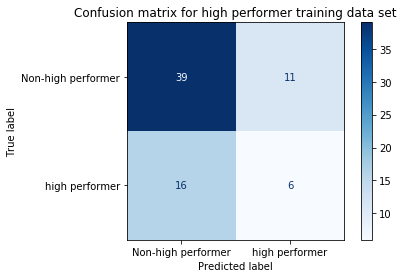

In [1225]:
disp = plot_confusion_matrix(smote_model, X_test_counts, y_test,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

# Tfidf Vectorizer

In [1168]:
vec2 = TfidfVectorizer(max_features=5000, ngram_range=(2,2))
X_train_tfidf = vec2.fit_transform(X_train) 
X_test_tfidf = vec2.transform(X_test)

In [1206]:
lr2 = LogisticRegression(class_weight="balanced", C = 1, solver='saga', penalty='elasticnet', l1_ratio=0.25)
lr2.fit(X_train_tfidf, y_train)
show_scores(lr2,X_train_tfidf, y_train, X_test_counts, y_test)

Training error:   0.06
Validation error: 0.38


In [1207]:
X_train_tfidf.todense()[1]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

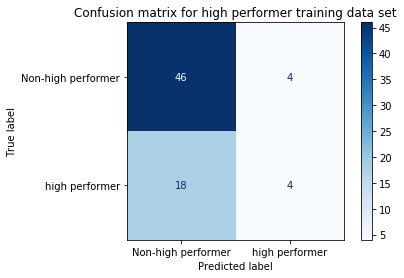

In [1208]:
disp = plot_confusion_matrix(lr2, X_test_tfidf, y_test,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

In [1209]:
# Get features (words in our case)
vocab = vec2.get_feature_names()
weights = lr2.coef_.flatten()

# Sort the coefficients in descending order 
inds = np.argsort(lr2.coef_.flatten())

# pick the first 20 as most informative features for negative reviews  
negative_words = [vocab[index] for index in inds[:20]]

# pick the last 20 features as most informative features for positive reviews  
positive_words = [vocab[index] for index in inds[-20:][::-1]]

neg_words_weights = [(weights[index]) for index in inds[:20]]
pos_words_weights = [(weights[index]) for index in inds[-20:][::-1]]

df = pd.DataFrame({'Neg feats':negative_words, 'Neg weights':neg_words_weights, 
                   'Pos feats':positive_words, 'Pos weights':pos_words_weights})
df

,Neg feats,Neg weights,Pos feats,Pos weights
0,high school,-0.611870,efficient service,0.590726
1,cash register,-0.331459,experience company,0.457277
2,health safety,-0.312851,product knowledge,0.424651
3,associate cashier,-0.297968,support technician,0.341090
4,excellent service,-0.273154,product service,0.337325
5,food prep,-0.213119,caesar make,0.329414
6,mohawk college,-0.201518,achieve target,0.328067
7,human resource,-0.200459,information systems,0.317773
8,fast paced,-0.172651,inventory control,0.299838
9,project management,-0.133526,business strategy,0.299459
